/home/alice/anaconda3/envs/lowergcc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


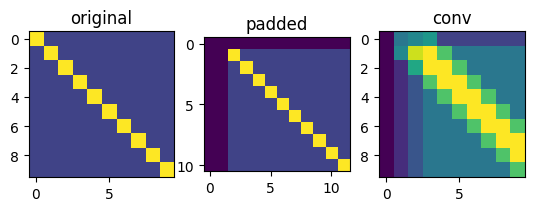

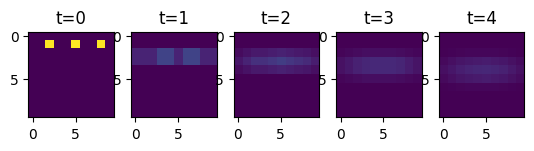

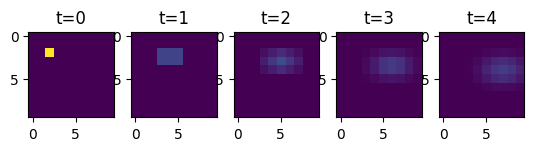

In [2]:
%load_ext autoreload
%autoreload 2

from pixelsnail import *
import torch
import matplotlib.pyplot as plt
import numpy as np

t = torch.eye(10, 10).view(1, 1, 10, 10) + 0.2
fig, ax = plt.subplots(1, 3)
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[0].set_title("original")

ker_v, ker_h = (2, 3)
pad = [ker_h-1, 0, ker_v-1, 0]
pad = nn.ZeroPad2d(pad)
out = pad(t)
ax[1].imshow(out[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[1].set_title("padded")

conv = nn.Conv2d(1, 1, (2, 3),
    stride=1, padding=0, bias=None)
conv.weight.data.fill_(0.33)

out = conv(out)
out = shift_right(out)
ax[2].imshow(out[0].permute(1, 2, 0).detach().numpy(), vmin=0, vmax=1)
ax[2].set_title("conv")

## experiment down
fig, ax = plt.subplots(1, 5)
casual_conv = CausalConv2d(1, 1, (2, 5), mode="down", weight_norm=False)
casual_conv.conv.weight.data.fill_(1/10)
casual_conv.conv.bias.data.fill_(0.00)

t = torch.zeros(1, 1, 10, 10)
t[:,:,1,2]=1.0
t[:,:,1,5]=1.0
t[:,:,1,8]=1.0
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy())
out = t
ax[0].set_title(f"t=0")

for i in range(4):
    out = casual_conv(out)
    if i == 0: out = shift_down(out)
    out_img = out[0].permute(1, 2, 0).detach().numpy()
    cx = ax[i+1].imshow(out_img,vmin=0, vmax=1)
    ax[i+1].set_title(f"t={i+1}")
    
## experiment downright
fig, ax = plt.subplots(1, 5)
casual_conv = CausalConv2d(1, 1, (2, 3), mode="downright", weight_norm=False)
casual_conv.conv.weight.data.fill_(0.2)
casual_conv.conv.bias.data.fill_(0.00)
 
t = torch.zeros(1, 1, 10, 10)
t[:,:,2, 2]=1.0
ax[0].imshow(t[0].permute(1, 2, 0).detach().numpy())
out = t
ax[0].set_title(f"t=0")

for i in range(4):
    out = casual_conv(out)
    if i == 0: out = shift_right(out)
    out_img = out[0].permute(1, 2, 0).detach().numpy()
    cx = ax[i+1].imshow(out_img,vmin=0, vmax=1)
    ax[i+1].set_title(f"t={i+1}")

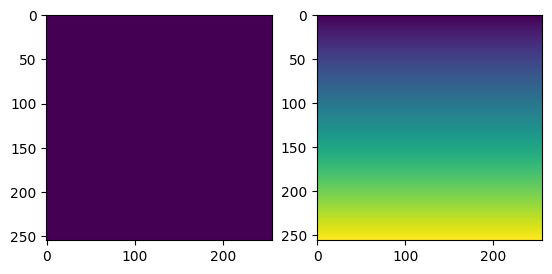

In [11]:
height = 256
width = 256
coord_y = (torch.arange(height).float() - height / 2) / height
coord_y = coord_y.view(1, 1, height, 1).expand(1, 1, height, width)
coord_x = (torch.arange(width).float() - width / 2) / width
coord_x = coord_x.view(1, 1, 1, width).expand(1, 1, height, width)
back0 = torch.full((1, 1, 255, 255), 0.5)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(back0[0].permute(1, 2, 0).detach().numpy())
ax[1].imshow(coord_y[0].permute(1, 2, 0).detach().numpy())

torch.Size([1, 1, 10, 10])


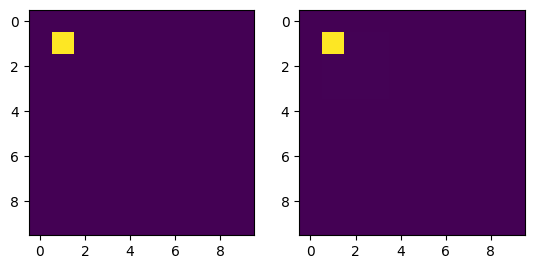

In [69]:
from pixelsnail import PixelSnail
snail = PixelSnail(10, 1, 10, (10, 10))

x = torch.zeros((1, 1, 10, 10), dtype=torch.long)
x[0, 0, 1, 1] = 1


res = GatedResBlock(1, 1, (3, 3), dropout=0.0, bias=False, mode="downright")
out = res(x.float())
print(out.shape)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x[0].permute(1, 2, 0).detach().numpy())
ax[1].imshow(out[0].permute(1, 2, 0).detach().numpy())

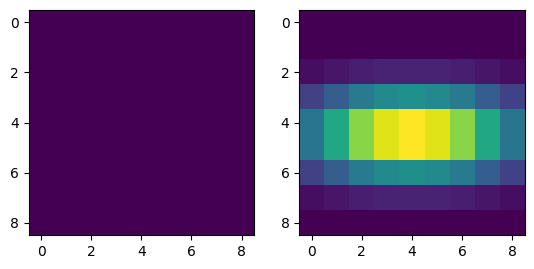

In [38]:
## experiment down
fig, ax = plt.subplots(1, 2)
casual_conv = CausalConv2d(1, 1, (2, 5), mode="down", weight_norm=False)
casual_conv.conv.weight.data.fill_(1.0)
casual_conv.conv.bias.data.fill_(0.00)

t = torch.zeros(1, 1, 9, 9)
t.requires_grad = True
out = shift_down(casual_conv(t))
out = casual_conv(out)
out = casual_conv(out)
out = casual_conv(out)
out = casual_conv(out)
ax[0].imshow(out[0].permute(1, 2, 0).detach().numpy())

s = torch.zeros(1, 1, 9, 9)
s[0, 0, 8, 4] = 1.0
s.requires_grad = False
criterion = nn.MSELoss()
loss = -criterion(out ,s)
loss.backward()

ax[1].imshow(t.grad[0].permute(1, 2, 0).detach().numpy())
